# Exploring the Effects of Perturbations on Saliency Map Generation

The link between saliency maps and model generalization is currently unclear. This is a simple notebook exploring how perturbations might effect saliency maps.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Images](#example-images)
* [Defining the "Application"](#defining-the-application)
* [Running the "Application"](#running-the-application)
    * [Classifier](#classifier)
    * [Saliency Generator](#saliency-generator)
    * [Results](#results)

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip uninstall -qy albumentations

In [2]:
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing albumentations...")
!{sys.executable} -m pip install -q albumentations
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing tabulate...")
!{sys.executable} -m pip install -q tabulate
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip -q install torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing xaitk-jatic...
Installing albumentations...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing tabulate...
Installing torch...
Installing torchvision...
Installing matplotlib...
Installing headless OpenCV...
Done!


In [ ]:
%matplotlib inline
from collections.abc import Hashable, Sequence
from dataclasses import dataclass, field
from typing import Any, Optional

import albumentations as album  # type: ignore
import maite.protocols.image_classification as ic
import numpy as np
import torch  # type: ignore
from datasets import load_dataset  # type: ignore
from matplotlib import pyplot as plt  # type: ignore
from scipy.stats import entropy
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from tabulate import tabulate
from transformers import (  # type:ignore
    AutoImageProcessor,  # type: ignore
    AutoModelForImageClassification,  # type: ignore
)
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency

from xaitk_jatic.interop.image_classification.model import JATICImageClassifier

/home/local/KHQ/stephen.crowell/.cache/pypoetry/virtualenvs/xaitk-jatic-OReYJURx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example Images <a name="example-images"></a>

We'll use example images from the CIFAR-10 test dataset, but this could be expanded to many images -- even across a dataset.

In [4]:
data = load_dataset("cifar10", split="test")
labels = data.features["label"].names  # type: ignore

data.set_transform(lambda x: {"image": x["img"], "label": x["label"]})  # type: ignore

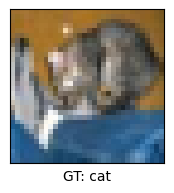

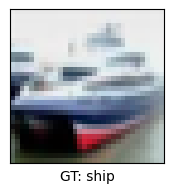

In [5]:
num_samples = 2
imgs = np.asarray([np.asarray(data[idx]["image"]) for idx in range(num_samples)])  # type:ignore
ground_truth: list[int] = [data[idx]["label"] for idx in range(num_samples)]  # type: ignore

for img, gt in zip(imgs, ground_truth):
    plt.figure(figsize=(2, 2))
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(f"GT: {labels[gt]}")
    _ = plt.imshow(img)

## Defining the "Application" <a name="defining-the-application"></a>

First we'll define a couple of dataclasses to keep track of results more easily:

In [6]:
@dataclass
class PerturbationResult:
    """
    Represents the results of a perturbation applied to an image, including the descriptor,
    modified image, saliency maps, and prediction details.

    Attributes:
        descriptor (str): A textual description of the perturbation applied (e.g., "ksize=3").
        img (np.ndarray): The perturbed image.
        sal_maps (np.ndarray): The saliency maps for the perturbed image.
        pred_class (int): The predicted class index for the perturbed image.
        pred_prob (float): The predicted probability for the predicted class.
    """

    descriptor: str
    img: np.ndarray
    sal_maps: np.ndarray
    pred_class: int
    pred_prob: float


@dataclass
class SaliencyResults:
    """
    Represents the saliency results for a reference image, including its saliency maps,
    ground truth, predictions, and perturbation results.

    Attributes:
        ref_img (np.ndarray): The reference image.
        ref_sal_maps (np.ndarray): The saliency maps for the reference image.
        gt (int): The ground truth class index for the reference image.
        pred_class (int): The predicted class index for the reference image.
        pred_prob (float): The predicted probability for the predicted class.
        perturbations (List[PerturbationResult]): A list of `PerturbationResult` objects representing
            the results of perturbations applied to the reference image.
    """

    ref_img: np.ndarray
    ref_sal_maps: np.ndarray
    gt: int
    pred_class: int
    pred_prob: float
    perturbations: list[PerturbationResult] = field(default_factory=list)

Next, we'll define a function to compute specified metrics upon our saliency map results.

In [ ]:
def compute_metrics(results: list[SaliencyResults], metrics: tuple[str, ...]) -> None:  # noqa:C901
    """
    Computes and displays specified metrics for saliency maps and their perturbations.

    Args:
        results (List[SaliencyResults]): List of saliency results, including reference images,
            saliency maps, and perturbation results.
        labels (Sequence[Hashable]): Sequence of class labels corresponding to class indices.
        metrics (tuple[str, ...]): tuple of metric names to compute. Supported metrics:
            - "Entropy"
            - "Pos Saliency Entropy"
            - "Neg Saliency Entropy"
            - "SSD"
            - "XCorr"

    Returns:
        None
    """

    def _compute_entropy(sal_map: np.ndarray, clip_min: Optional[float], clip_max: Optional[float]) -> float:
        """
        Computes the entropy of a saliency map.

        Args:
            sal_map (np.ndarray): The saliency map.
            clip_min (float): Minimum clipping value.
            clip_max (float): Maximum clipping value.

        Returns:
            float: The entropy of the saliency map.
        """
        if clip_min is not None or clip_max is not None:
            s = np.clip(sal_map, clip_min, clip_max)
        else:
            s = (sal_map - sal_map.min()) / (sal_map.max() - sal_map.min())
        return entropy(s.ravel(), base=2)  # type: ignore

    def _compute_ssd(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
        """
        Computes the sum of squared differences (SSD) between two saliency maps.

        Args:
            sal_map (np.ndarray): The saliency map.
            ref_sal_map (np.ndarray): The reference saliency map.

        Returns:
            float: The SSD value.
        """
        sum_sq_diff = np.sum(np.power(np.subtract(sal_map, ref_sal_map), 2))
        norm = np.sqrt(np.sum(np.power(sal_map, 2)) * np.sum(np.power(ref_sal_map, 2)))
        if not norm:
            return np.inf
        return sum_sq_diff / norm

    def _compute_xcorr(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
        """
        Computes the normalized cross-correlation between two saliency maps.

        Args:
            sal_map (np.ndarray): The saliency map.
            ref_sal_map (np.ndarray): The reference saliency map.

        Returns:
            float: The cross-correlation value.
        """

        def _normalize(s: np.ndarray) -> tuple[np.ndarray, bool]:
            s -= s.mean()
            std = s.std()

            if std:
                s /= std

            return s, std == 0

        s_1, c_1 = _normalize(sal_map.copy())
        s_2, c_2 = _normalize(ref_sal_map.copy())

        if c_1 and not c_2:
            return 0.0
        return np.corrcoef(s_1.flatten(), s_2.flatten())[0, 1]

    def _compute_metric(sal_map: np.ndarray, ref_sal_map: np.ndarray, m: str) -> float:  # noqa:C901
        """
        Computes a specific metric for a saliency map.

        Args:
            sal_map (np.ndarray): The saliency map.
            ref_sal_map (np.ndarray): The reference saliency map.
            m (str): The name of the metric.

        Returns:
            float: The computed metric value.
        """
        if m == "entropy":
            return _compute_entropy(sal_map, None, None)
        if m == "pos saliency entropy":
            return _compute_entropy(sal_map, 0, 1)
        if m == "neg saliency entropy":
            return _compute_entropy(sal_map, -1, 0)
        if m == "ssd":
            return _compute_ssd(sal_map, ref_sal_map)
        if m == "xcorr":
            return _compute_xcorr(sal_map, ref_sal_map)
        return np.nan

    def _generate_row(sal_map: np.ndarray, ref_sal_map: np.ndarray, row_label: str) -> list[Hashable]:
        """
        Generates a row of metric values for a saliency map.

        Args:
            sal_map (np.ndarray): The saliency map.
            ref_sal_map (np.ndarray): The reference saliency map.
            row_label (str): Label for the row.

        Returns:
            List[Hashable]: A list containing the row label and computed metrics.
        """
        r: list[Hashable] = [row_label]

        r.extend([(_compute_metric(sal_map, ref_sal_map, metric.lower().strip())) for metric in metrics])
        return r

    headers = ["Perturbation"]
    headers.extend(list(metrics))
    for res in results:
        rows = []

        rows.append(_generate_row(res.ref_sal_maps[res.gt], res.ref_sal_maps[res.gt], "Ref Image"))

        rows = [
            _generate_row(pert.sal_maps[res.gt], res.ref_sal_maps[res.gt], f"{pert.descriptor}")
            for pert in res.perturbations
        ]

        print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

We'll also define a function to display all generated saliency maps.

In [ ]:
def display_results(results: list[SaliencyResults], labels: Sequence[Hashable]) -> None:  # noqa:C901
    """
    Displays saliency maps and associated images for a set of results.

    Args:
        results (List[SaliencyResults]): A list of saliency results, including reference images,
            saliency maps, and perturbation results.
        labels (Sequence[Hashable]): A sequence of class labels corresponding to the indices of classes.

    Returns:
        None
    """
    num_classes = len(labels)

    def _plot_img(img: np.ndarray, descriptor: str = "") -> None:
        """
        Plots a single reference image.

        Args:
            img (np.ndarray): The reference image to be plotted.
            descriptor (str, optional): A description to label the image. Defaults to "".

        Returns:
            None
        """
        plt.subplot(2, num_cols, 1)
        plt.imshow(img, cmap="gray")
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(descriptor)

    def _plot_rows(sal_maps: np.ndarray, plot_idxes: Optional[list[int]] = None) -> None:
        """
        Plots rows of saliency maps.

        Args:
            sal_maps (np.ndarray): The saliency maps to be plotted.
            plot_idxes (Optional[List[int]], optional): Indices of the saliency maps to be plotted.
                If None, plots all saliency maps. Defaults to None.

        Returns:
            None
        """
        plot_idxes = list(range(len(sal_maps))) if plot_idxes is None else [*set(plot_idxes)]
        n_cols = min(num_cols - 1, len(plot_idxes))
        n_rows = 2

        num_imgs = 0
        for r in range(n_rows):
            col_offset = 2
            if r > 0:
                col_offset = 3
            for c in range(r * n_cols, min(r * n_cols + n_cols, len(plot_idxes))):
                plt.subplot(n_rows, num_cols, c + col_offset)
                im = plt.imshow(sal_maps[plot_idxes[c]], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[plot_idxes[c]]}")
                num_imgs += 1

                if num_imgs == len(plot_idxes):
                    fig = plt.gcf()
                    cax = fig.add_axes((0.38, 0.60, 0.01, 0.21))  # type: ignore # tweaked for this particular example
                    plt.colorbar(im, cax=cax)

    for res in results:
        plt.figure(figsize=(10, 5))
        num_cols = np.ceil(num_classes / 2).astype(int) + 1
        pred = f"{labels[res.pred_class]} ({res.pred_prob:.2f})"
        _plot_img(res.ref_img, f"Ref Img\nGT: {labels[res.gt]}\nPred: {pred}")
        _plot_rows(res.ref_sal_maps, [res.gt])

        for pert in res.perturbations:
            plt.figure(figsize=(10, 5))
            pred = f"{labels[pert.pred_class]} ({pert.pred_prob:.2f})"
            _plot_img(pert.img, f"{pert.descriptor}\nPred: {pred}")
            _plot_rows(pert.sal_maps, [res.gt])

    plt.show()

Finally, we'll define the "application" which perturbs the given input image(s) to varying degrees and generates saliency maps. In this case, we'll perturb the images using a Gaussian Blur while varying the `ksize` parameter to achieve different levels of degradation.

In [ ]:
def generate_perturbed_sal_maps(  # noqa:C901
    images: np.ndarray,
    ground_truth: list[int],
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    ksizes: tuple[int, ...],
    display_maps: bool = True,
    metrics: tuple[str, ...] = ("Pos Saliency Entropy", "Neg Saliency Entropy", "Entropy", "SSD", "XCorr"),
) -> list[SaliencyResults]:
    """
    Generates saliency maps for reference images and perturbed versions, computes metrics,
    and optionally displays the saliency maps.

    Args:
        images (np.ndarray): Array of input images (shape: [batch_size, height, width, channels]).
        ground_truth (list[int]): list of ground truth class indices for the input images.
        image_classifier (ClassifyImage): The image classifier to generate predictions.
        saliency_generator (GenerateImageClassifierBlackboxSaliency): The saliency generator to compute saliency maps.
        ksizes (tuple[int, ...]): tuple of kernel sizes for perturbations.
        display_maps (bool, optional): Whether to display saliency maps for each image. Defaults to True.
        metrics (tuple[str, ...], optional): list of metric names to compute. Defaults to
            ("Pos Saliency Entropy", "Neg Saliency Entropy", "Entropy", "SSD", "XCorr").

    Returns:
        list[SaliencyResults]: A list of `SaliencyResults` containing saliency maps, predictions,
        and perturbation results for each input image.
    """
    # Get class labels
    labels = image_classifier.get_labels()

    def _max_class(probs: dict[str, Any]) -> str:
        v = list(probs.values())
        k = list(probs.keys())
        return k[v.index(max(v))]

    # Generate saliency maps
    results = list()
    for idx, img in enumerate(images):
        print(f"Generating saliency maps for reference image (image {idx+1} of {len(images)})")
        sal_maps = saliency_generator(img, image_classifier)
        probs = next(image_classifier.classify_images(np.expand_dims(img, axis=0)))
        pred_class = _max_class(probs)
        res = SaliencyResults(
            ref_img=np.copy(img),
            ref_sal_maps=sal_maps,
            gt=ground_truth[idx],
            pred_class=labels.index(pred_class),
            pred_prob=probs[pred_class],
        )

        for k in ksizes:
            print(f"Generating saliency maps for ksize={k} (ref image {idx+1} of {len(images)})")
            img_out = album.gaussian_blur(np.copy(img), ksize=k)
            sal_maps = saliency_generator(img_out, image_classifier)
            probs = next(image_classifier.classify_images(np.expand_dims(img_out, axis=0)))
            pred_class = _max_class(probs)

            pert = PerturbationResult(
                descriptor=f"ksize={k}",
                img=img_out,
                sal_maps=sal_maps,
                pred_class=labels.index(pred_class),
                pred_prob=probs[pred_class],
            )

            res.perturbations.append(pert)

        results.append(res)

    for result in results:
        # Plot each image in set with saliency maps
        if display_maps:
            display_results([result], labels)

        # Compute metrics
        compute_metrics([result], metrics)

    return results

## Running the "Application" <a name="running-the-application"></a>

### Classifier <a name="classifier"></a>

We'll use a JATIC protocol-based classifier, along with the relevant `xaitk-saliency` adapter. We define a protocol-based classifier here, but this can be any protocol-compliant classifier.

In [10]:
class HuggingFaceClassifier:
    """
    A Hugging Face-based image classifier that uses pre-trained image classification models.

    Attributes:
        image_processor (AutoImageProcessor): The processor for preparing input images for the model.
        model (AutoModelForImageClassification): The pre-trained Hugging Face model for image classification.
        device (str): The device on which the model will run (e.g., "cpu" or "cuda").
    """

    def __init__(self, model_name: str, device: str) -> None:
        """
        Initializes the HuggingFaceClassifier with a pre-trained model and a device.

        Args:
            model_name (str): The name of the pre-trained model from Hugging Face.
            device (str): The device to use for running the model (e.g., "cpu" or "cuda").
        """
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.device = device

        self.model.eval()
        self.model.to(device)

    def id2label(self) -> dict[int, Hashable]:
        """
        Retrieves the mapping of class IDs to labels from the model's configuration.

        Returns:
            Dict[int, Hashable]: A dictionary mapping class IDs to human-readable labels.
        """
        return self.model.config.id2label

    def __call__(self, batch: ic.InputBatchType) -> ic.TargetBatchType:
        """
        Processes a batch of images and returns the model's predictions.

        Args:
            batch (ic.InputBatchType): A batch of images in the format required by the model.

        Raises:
            ValueError: If the input batch does not have 4 dimensions (batch_size, channels, height, width).

        Returns:
            ic.TargetBatchType: The predicted class probabilities for the batch.
        """
        # tensor bridging
        model_input = torch.as_tensor(batch)
        if model_input.ndim != 4:
            raise ValueError("number of input dimensions should be 4")

        # preprocess
        hf_inputs = self.image_processor(model_input, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            return self.model(**hf_inputs).logits.softmax(1).detach().cpu()


jatic_classifier: ic.Model = HuggingFaceClassifier(
    model_name="aaraki/vit-base-patch16-224-in21k-finetuned-cifar10",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

In [ ]:
classifier = JATICImageClassifier(classifier=jatic_classifier, ids=list(jatic_classifier.id2label()))

### Saliency Generator <a name="saliency-generator"></a>

We'll use the `SlidingWindowStack` blackbox saliency generator.

In [12]:
sal_generator = SlidingWindowStack(window_size=(4, 4), stride=(2, 2), threads=4)
sal_generator.fill = (128, 128, 128)

### Results <a name="results"></a>

Note: for clarity, we'll only be performing the saliency analysis with respect to the groundtruth class, but this analysis could also be applied to the predicted class, which may be useful in cases where the groundtruth and predictions may differ.

Generating saliency maps for reference image (image 1 of 2)


/tmp/ipykernel_173402/2710548664.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  input = torch.as_tensor(batch)


Generating saliency maps for ksize=3 (ref image 1 of 2)
Generating saliency maps for ksize=5 (ref image 1 of 2)
Generating saliency maps for ksize=7 (ref image 1 of 2)
Generating saliency maps for reference image (image 2 of 2)
Generating saliency maps for ksize=3 (ref image 2 of 2)
Generating saliency maps for ksize=5 (ref image 2 of 2)
Generating saliency maps for ksize=7 (ref image 2 of 2)


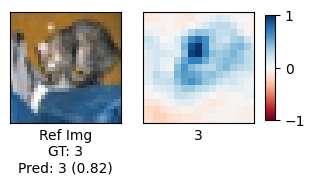

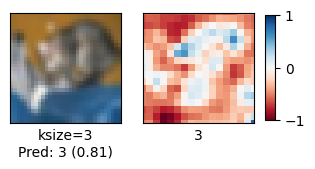

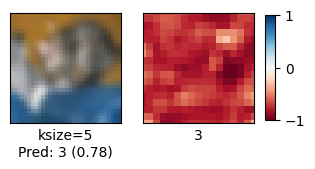

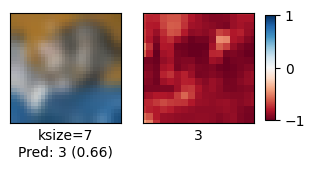

╒════════════════╤════════════════════════╤════════════════════════╤═══════════╤═════════╤═══════════╕
│ Perturbation   │   Pos Saliency Entropy │   Neg Saliency Entropy │   Entropy │     SSD │     XCorr │
╞════════════════╪════════════════════════╪════════════════════════╪═══════════╪═════════╪═══════════╡
│ Ref Image      │                9.02402 │                8.06992 │   9.75502 │ 0       │  1        │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=3        │                7.10894 │                9.44422 │   9.86029 │ 2.30664 │  0.542762 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=5        │              nan       │                9.98267 │   9.86491 │ 4.22985 │ -0.13633  │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=7        │              nan       │                9.98875 │   9.

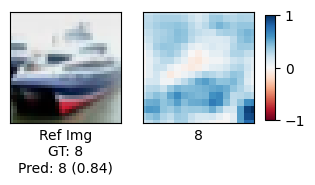

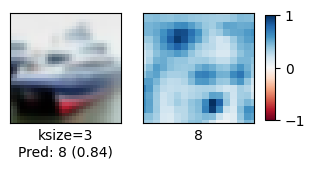

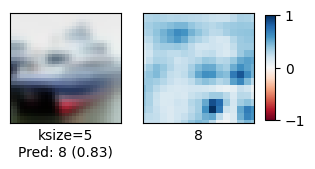

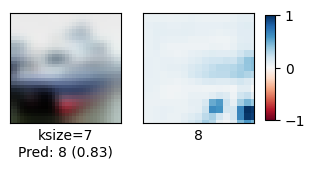

╒════════════════╤════════════════════════╤════════════════════════╤═══════════╤══════════╤══════════╕
│ Perturbation   │   Pos Saliency Entropy │   Neg Saliency Entropy │   Entropy │      SSD │    XCorr │
╞════════════════╪════════════════════════╪════════════════════════╪═══════════╪══════════╪══════════╡
│ Ref Image      │                9.72334 │                5.25899 │   9.85435 │ 0        │ 1        │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=3        │                9.89407 │              nan       │   9.87751 │ 0.354642 │ 0.335318 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=5        │                9.86679 │              nan       │   9.85166 │ 0.322252 │ 0.274194 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=7        │                9.48282 │              nan       │   9.

In [ ]:
results = generate_perturbed_sal_maps(
    images=imgs,
    ground_truth=ground_truth,
    image_classifier=classifier,
    saliency_generator=sal_generator,
    ksizes=(3, 5, 7),
)

We can visually see that as the quality of the input image degrades (more perturbation), the quality of the generated saliency maps similarly degrades.

In an attempt to quantify these differences, we've also computed several metrics:

#### Entropy <a name="entropy"></a>

If we compare entropy values using both positive and negative saliency we don't see much of a change across degradations. This is likely due to negative and positive saliency "fighting" each other as degradation increases (as one increases, the other decreases).

If we consider entropy values computed from only positive or only negative saliency values, we see differences in values. Looking at the dominant saliency type (i.e. negative/red for the cat, positive/blue for the ship), we can see that as degradation gets worse, entropy reduces -- to a certain point. The reduction in entropy likely corresponds to the classifier being less able to identify key features that led to the original probability distribution for the reference image due to the degradion. Eventually these features may become so degraded that the classifier begins predicting with very low confidence or nan values if there are no instances of the dominant saliency type. 

If we look at the opposite saliency type for each reference image, we see a very slight increase in entropy as degradation increases. This potentially indicates that the degradation introduces noise that the classifier misidentifies as a contraindicator for the ground truth class, but more likely corresponds to the classifier predicting with less confidence due to the loss in higher quality features.

#### Sum of Squared Differences (SSD) <a name="ssd"></a>

(0 is most similar) The sum of squared differences lets us quantitatively confirm that as degradation gets worse, saliency maps are increasiningly dissimilar to the original reference saliency map. However, the metric doesn't give us much insight into what is actually happening to create these differences.

#### Cross-Correlation (XCorr) <a name="cross-correlation"></a>

(1 is most similar) Cross-correlations tell us similar information as SSD. The introduction of negative correlation values, however, potentially indicates that the saliency maps begin to become the "opposite" of the original reference saliency maps. The aligns with the pattern we saw with positive/negative saliency entropy -- we see an introduction of the opposite saliency as the image becomes more degraded and the classifier becomes more confused. The likely doesn't occur with the ship reference image as it was more strongly salient in one direction compared to the cat reference image was contained a more balanced mix of both positive and negative saliency.